In [1]:
import sys
sys.path.append('..')

In [2]:
import difflib as dl
import regex as re
import statistics as stat
import string
import subprocess
import tempfile
import unicodedata
import warnings
from collections import Counter, defaultdict, namedtuple
from dataclasses import dataclass, field
from functools import reduce
from itertools import groupby, combinations
from pathlib import Path
from pprint import pp
from typing import Union
from types import SimpleNamespace

import numpy as np
import pandas as pd
from Bio import SeqUtils
from Bio.Seq import Seq
from IPython.display import display
from ipywidgets import interact
from PIL import Image, ImageDraw

from digi_leap.pylib import (
    db,
    image_util as iu,
    label_transforms as lt,
    line_align_subs as subs,
    line_align_py as la,
    vocab,
)

In [3]:
DATA = Path('..') / 'data' / 'sernec'
SHEETS = DATA / 'sheets'
DB = DATA / 'sernec.sqlite'

In [4]:
SHEETS = [dict(s) for s in db.select_sheets(DB)]

In [5]:
ocr = [dict(ocr) for ocr in db.select_ocr(DB)]
OCR = defaultdict(list)
for o in ocr:
    OCR[o['label_id']].append(o)

In [6]:
LABELS = [dict(lb) for lb in db.select_labels(DB) if lb['label_id'] in OCR]
LABELS = [lb for lb in LABELS if lb['class'] == 'Typewritten']

In [7]:
def get_label(idx):
    with warnings.catch_warnings():  # Turn off EXIF warnings
        warnings.filterwarnings("ignore", category=UserWarning)
        label = LABELS[idx]
        path = Path('..') / label['path']
        sheet = Image.open(path)
        image = sheet.crop((label["left"], label["top"],
                            label["right"], label["bottom"]))
        return label, image

In [8]:
def transform_label(label, image):
    trans = lt.transform_label('deskew', image)
    trans = trans.convert('RGB')
    return trans

In [9]:
def filter_boxes(ocr_boxes, image_height, conf=0.25, height_threshold=0.25, std_devs=2.0):
    """Remove problem bounding boxes from the data frame.

    Excuses for removing boxes include:
    - Remove bounding boxes with no text.
    - Remove boxes with a low confidence score (from the OCR engine) for the text.
    - Remove boxes that are too tall relative to the label.
    - Remove boxes that are really skinny or really short.
    """
    if len(ocr_boxes) < 2:
        return ocr_boxes

    too_tall = round(image_height * height_threshold)

    widths = [b['right'] - b['left'] for b in ocr_boxes]
    heights = [b['bottom'] - b['top'] for b in ocr_boxes]

    too_short, too_thin = 0.0, 0.0
    if len(ocr_boxes) >= 2:
        too_short = round(stat.mean(widths) - (std_devs * stat.stdev(widths)))
        too_thin = round(stat.mean(heights) - (std_devs * stat.stdev(heights)))

    filtered = []
    for box in ocr_boxes:
        width = box['right'] - box['left']
        height = box['bottom'] - box['top']

        # Remove boxes with nothing in them
        box['text'] = box['text'].strip()
        if not box['text']:
            continue

        # Remove boxes with low confidence
        if box['conf'] < conf:
            continue

        # Remove boxes that are too tall
        if height >= too_tall:
            continue

        # Remove boxes that are very thin or very short
        if width < too_thin or height < too_short:
            continue

        # It passes
        filtered.append(box)

    return filtered

In [10]:
COLORS = {
    ('deskew', 'tesseract'): 'red',
    ('deskew', 'easy'): 'blue',
    ('binarize', 'tesseract'): 'green',
    ('binarize', 'easy'): 'orange',
}


def display_boxes(ocr_boxes, image):
    draw = ImageDraw.Draw(image)

    for o in ocr_boxes:
        box = [o['left'], o['top'], o['right'], o['bottom']]
        color = COLORS[(o['pipeline'], o['engine'])]
        draw.rectangle(box, outline=color, width=2)

In [11]:
def trim_boxes(ocr_boxes, label):
    ocr = OCR[ocr_boxes['label_id']]

    for o in ocr:
        box = [o['left'], o['top'], o['right'], o['bottom']]
        box = label.crop(box)
        if box.size[0] == 0 or box.size[1] == 0:
            continue
        proj = iu.profile_projection(box)
        above = np.where(proj > 0)
        if above and len(above[0]) > 0:
            o['bottom'] = o['top'] + above[0][-1]
            o['top'] += above[0][0]

In [12]:
@dataclass
class Row:
    boxes: list[dict] = field(default_factory=list)

    def overlap(self, box, eps=1):
        last = self.boxes[-1]
        smallest = min(last['bottom'] - last['top'],
                       box['bottom'] - box['top'])
        y_min = max(last['top'], box['top'])
        y_max = min(last['bottom'], box['bottom'])
        inter = max(0, y_max - y_min)
        return inter / (smallest + eps)

In [13]:
def get_rows(ocr_boxes, vert_overlap=0.3):
    boxes = sorted(ocr_boxes, key=lambda b: b['left'])
    rows: list[Row] = []

    for box in boxes:
        over = [(r.overlap(box), r) for r in rows]
        over = sorted(over, key=lambda o: -o[0])

        if over and over[0][0] > vert_overlap:
            row = over[0][1]
            row.boxes.append(box)
        else:
            row = Row()
            row.boxes.append(box)
            rows.append(row)

    rows = sorted(rows, key=lambda r: r.boxes[0]['top'])
    return rows

In [14]:
# Sort the strings by levenshtein distance
# levenshtein_all returns a sorted array of tuples (score, index_1, index_2)

def distance_sort(copies):
    if len(copies) < 3:
        return copies
    distances = la.levenshtein_all(copies)
    i, j = distances[0][1:]
    hits = {i, j}
    ordered = [copies[i], copies[j]]
    while len(hits) < len(copies):
        for d in distances:
            i, j = d[1:]
            if i in hits and j not in hits:
                hits.add(j)
                ordered.append(copies[j])
                break
            elif j in hits and i not in hits:
                hits.add(i)
                ordered.append(copies[i])
                break
    return ordered

In [15]:
CATEGORY = {
    'Lu': 20,  # Uppercase_Letter
    'Ll': 20,  # Lowercase_Letter
    'Lt': 20,  # Titlecase_Letter
    'Lm': 20,  # Modifier_Letter
    'Lo': 20,  # Other_Letter

    'Nd': 30,  # Decimal_Number

    'Nl': 60,  # Letter_Number
    'No': 60,  # Other_Number

    'Pc': 70,  # Connector_Punctuation
    'Pd': 40,  # Dash_Punctuation
    'Ps': 50,  # Open_Punctuation
    'Pe': 50,  # Close_Punctuation
    'Pi': 50,  # Initial_Punctuation
    'Pf': 50,  # Final_Punctuation
    'Po': 10,  # Other_Punctuation

    'Sm': 99,  # Math_Symbol
    'Sc': 90,  # Currency_Symbol
    'So': 90,  # Other_Symbol

    'Zs': 80,  # Space_Separator
}

PO = {
    '.': 1,
    ',': 2,
    ':': 2,
    ';': 2,
    '!': 5,
    '"': 5,
    "'": 5,
    '*': 5,
    '/': 5,
    '%': 6,
    '&': 6,
}


def char_key(char):
    order = CATEGORY[unicodedata.category(char)]
    order = PO.get(char, order)
    return order, char

In [16]:
def char_options(aligned):
    options = []
    str_len = len(aligned[0])

    for i in range(str_len):
        counts = Counter(s[i] for s in aligned).most_common()
        count = counts[0][1]
        chars = [c[0] for c in counts if c[1] == count]
        chars = sorted(chars, key=char_key)  # Sort order is a fallback
        options.append(chars)
    return options

In [17]:
def char_consensus(options):
    return ''.join([o[0] for o in options])

In [18]:
def get_choices(options):
    end = len(options)
    all_choices = []
    def build_choices(opts, choice):
        if not opts:
            ln = ''.join(choice)
            all_choices.append(ln)
            return
        for o in opts[0]:
            build_choices(opts[1:], choice + [o])
    build_choices(options, [])
    return all_choices

In [19]:
def word_consensus_key(choice):
    hits = vocab.text_hits(choice)
    count = sum(1 for c in choice if c not in '⋄_ ')
    return hits, -count

In [20]:
def word_consensus(options):
    choices = get_choices(options)
    choices = sorted(choices, key=word_consensus_key)
    return choices[0]

In [23]:
SUB = [
    # Remove gaps
    ('⋄', ''),

    # Replace underscores with spaces
    ('_', ' '),

    # Remove space before some punct: x . -> x.
    (r'(\S)\s([;:.,\)\]\}])', r'\1\2'),

    # Trim internal spaces
    (r'\s\s+', ' '),

    # Convert single capital letter, punct to capital dot: L' -> L.
    (r'(\p{L}\s\p{Lu})\p{Po}', r'\1.'),

    # Add spaces around an &
    (r'(\w)&', r'\1 &'),
    (r'&(\w)', r'& \1'),
]


def sub(ln):
    for old, new in SUB:
        ln = re.sub(old, new, ln)
    return ln

Herbarium of the University of North Carolina
SOUTH CAROLINA
Charleston County
Gnaphaliu peregrinum Fern,
railroad right-of-way, Johns Island Station on
County Rt. 20 (wes t of Charleston).
Harry E. Ahles 22002 April 2, 1957
with John G. Haesloop
Collected for the "Flora of the Carolinas"


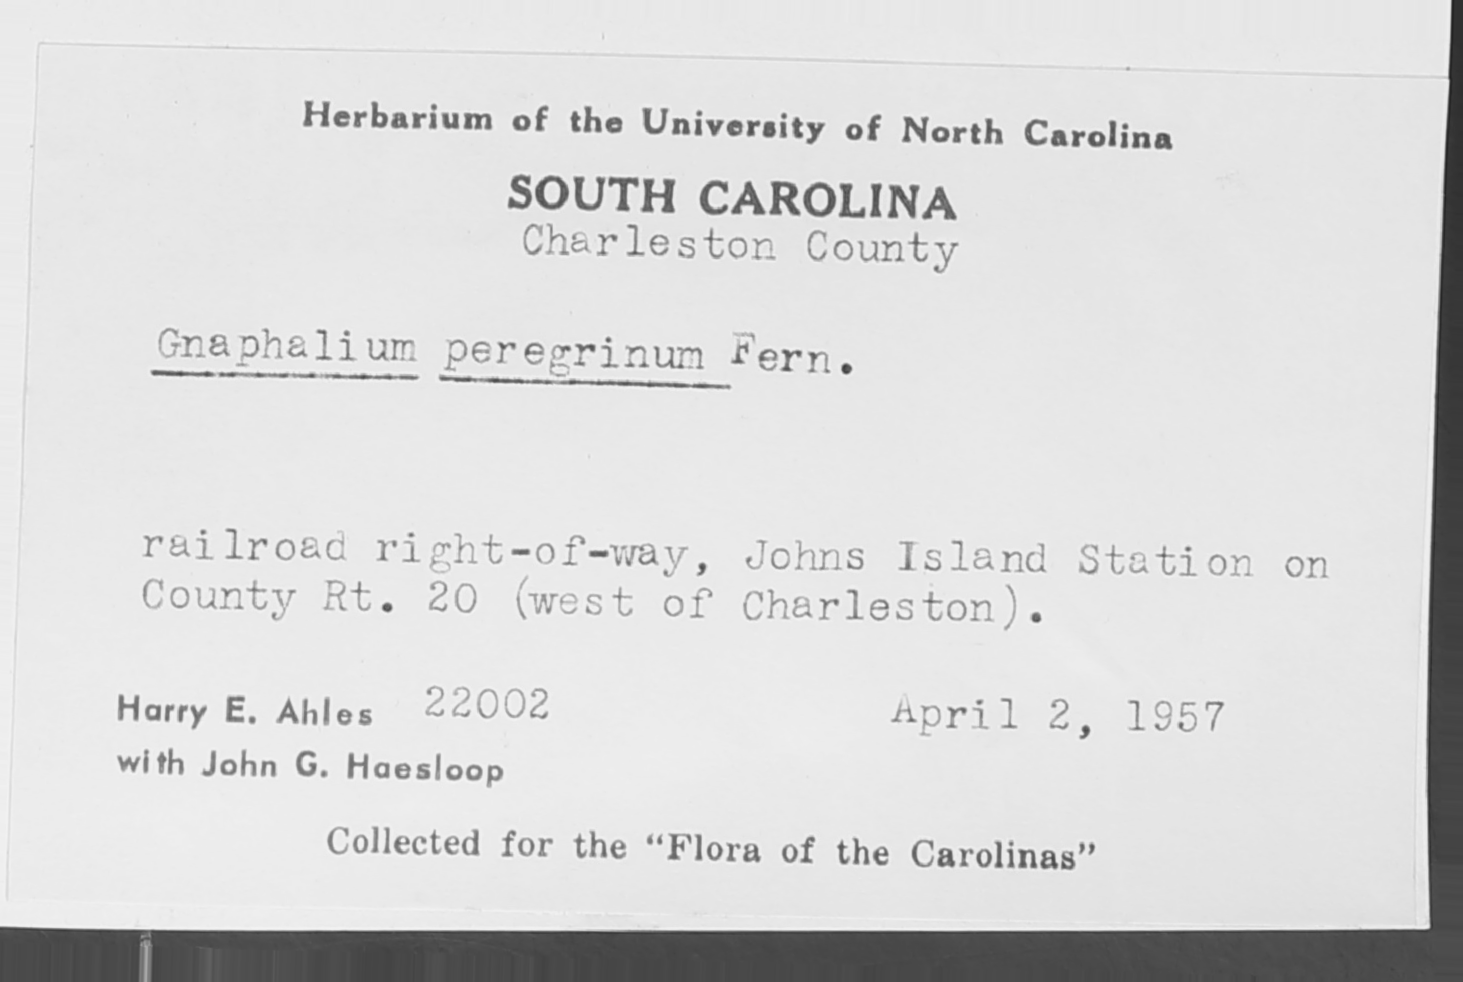

In [28]:
def build_ocr(idx, threshold=2**16):
    label, image = get_label(idx)
    image = transform_label(label, image)
    ocr_boxes = OCR[label['label_id']]
    ocr_boxes = filter_boxes(ocr_boxes, image.size[1])
    # trim_boxes(ocr_boxes, label)
    # display_boxes(ocr_boxes, image)
    rows = get_rows(ocr_boxes)
    lines = []
    for row in rows:
        copies = []
        row.boxes = sorted(
            row.boxes, key=lambda b: (b['engine'], b['pipeline']))
        combos = groupby(row.boxes, key=lambda b: (b['engine'], b['pipeline']))

        for (engine, pipeline), boxes in combos:
            text = ' '.join([b['text'] for b in boxes])
            copies.append(text)

        if len(copies) < 2:
            continue

        copies = distance_sort(copies)

        aligned = la.align_all(copies, subs.SUBS, gap=-3.0)

        options = char_options(aligned)
        count = reduce(lambda x, y: x * len(y), options, 1)
        if count == 1 or count > threshold:
            ln = char_consensus(options)
        else:
            ln = word_consensus(options)

        ln = sub(ln)
        lines.append(ln)

    print('\n'.join(lines))
    display(image)


# interact(build_ocr, idx=(0, len(LABELS) - 1));
# build_ocr(0)  # Happy flow
# build_ocr(2)  # The date is wrong
build_ocr(11112)  # wes t of Charleston